# Seq2Seq Q&A Chatbot 구현

### 데이터 취득

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/songys/Chatbot_data/refs/heads/master/ChatbotData.csv')
df = df[['Q', 'A']]
df

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.
...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
dtypes: object(2)
memory usage: 184.9+ KB


In [3]:
# 토크나이저 학습용 말뭉치 파일 생성
corpus_path = 'qa_corpus.txt'
with open(corpus_path, 'w', encoding='utf-8') as f:
    for text in df['Q'].tolist() + df['A'].tolist():
        f.write(f"{text}\n")

### 데이터 전처리

##### 토크나이저 학습 (sentencepiece 활용)

- 접두사, 접미사 처리 (bos, eos)
    - Train() 인자 cmd 옵션을 추가 (`<bos>, <eos>, <pad>, <oov>...`)
    - set_encode_extra_options(':')<br>
        set_encode_extra_options('bos:')<br>
        set_encode_extra_options(':eos')<br>
        set_encode_extra_options('bos:eos')

In [4]:
import sentencepiece as spt

model_prefix = 'qa_tokenizer'
vocab_size = 5000
cmd = f'--input={corpus_path} --model_prefix={model_prefix} --vocab_size={vocab_size} --bos_id=1 --bos_piece=<s> --eos_id=2 --eos_piece=</s>'

spt.SentencePieceTrainer.train(cmd)

##### 학습용 데이터 Q_input, A_input, A_target 생성

In [5]:
# 학습된 토커나이저 모델 로드
sp = spt.SentencePieceProcessor()
sp.load(f'{model_prefix}.model')

Q_inputs, A_inputs, A_targets = [], [], []

BOS_ID = sp.bos_id()
EOS_ID = sp.eos_id()

for q, a in zip(df['Q'], df['A']):
    q_ids = sp.encode_as_ids(q)
    a_ids = sp.encode_as_ids(a)

    Q_inputs.append(q_ids)
    A_inputs.append([BOS_ID] + a_ids)
    A_targets.append(a_ids + [EOS_ID])

len(Q_inputs), len(A_inputs), len(A_targets)

(11823, 11823, 11823)

In [6]:
# 패딩
from tensorflow.keras.preprocessing.sequence import pad_sequences

q_max_len = max(len(seq) for seq in Q_inputs)
a_max_len = max(len(seq) for seq in A_inputs)

Q_inputs_padded = pad_sequences(Q_inputs, maxlen=q_max_len, padding='post')
A_inputs_padded = pad_sequences(A_inputs, maxlen=a_max_len, padding='post')
A_targets_padded = pad_sequences(A_targets, maxlen=a_max_len, padding='post')

### 모델 생성 및 학습

##### 인코더 생성

In [7]:
VOCAB_SIZE = sp.get_piece_size()
EMBEDDING_DIM = 100
LATENT_DIM = 512

In [8]:
from tensorflow.keras import layers, models

encoder_inputs = layers.Input(shape=(q_max_len,))
embedding_layer = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
x = embedding_layer(encoder_inputs)

encoder_outputs, state_h, state_c = layers.LSTM(LATENT_DIM, return_state=True)(x)
encoder_states = [state_h, state_c]

encoder_model = models.Model(inputs=encoder_inputs, outputs=encoder_states)
encoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 25, 100)        │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ [(None, 512), (None,   │     1,255,424 │
│                                 │ 512), (None, 512)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,755,424 (6.70 MB)

 Trainable params: 1,755,424 (6.70 MB)

 Non-trainable params: 0 (0.00 B)

##### 디코더(teacher-forcing 모델) 생성

In [9]:
decoder_inputs = layers.Input(shape=(a_max_len,))

decoder_embedding_layer = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = decoder_lstm(x, initial_state=encoder_states)

decoder_dense = layers.Dense(VOCAB_SIZE, activation='softmax')
decoder_outputs = decoder_dense(x)

decoder_teacher_forcing_model = models.Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs=decoder_outputs
)
decoder_teacher_forcing_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 25, 100)   │    500,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 37, 100)   │    500,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,255,424 │ embedding[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 37, 512), │  1,255,424 │ embedding_1[0][0… │
│                     │ (None, 512),      │            │ lstm[0][1],       │
│                     │ (None, 512)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 37, 5000)  │  2,565,000 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,075,848 (23.18 MB)

 Trainable params: 6,075,848 (23.18 MB)

 Non-trainable params: 0 (0.00 B)

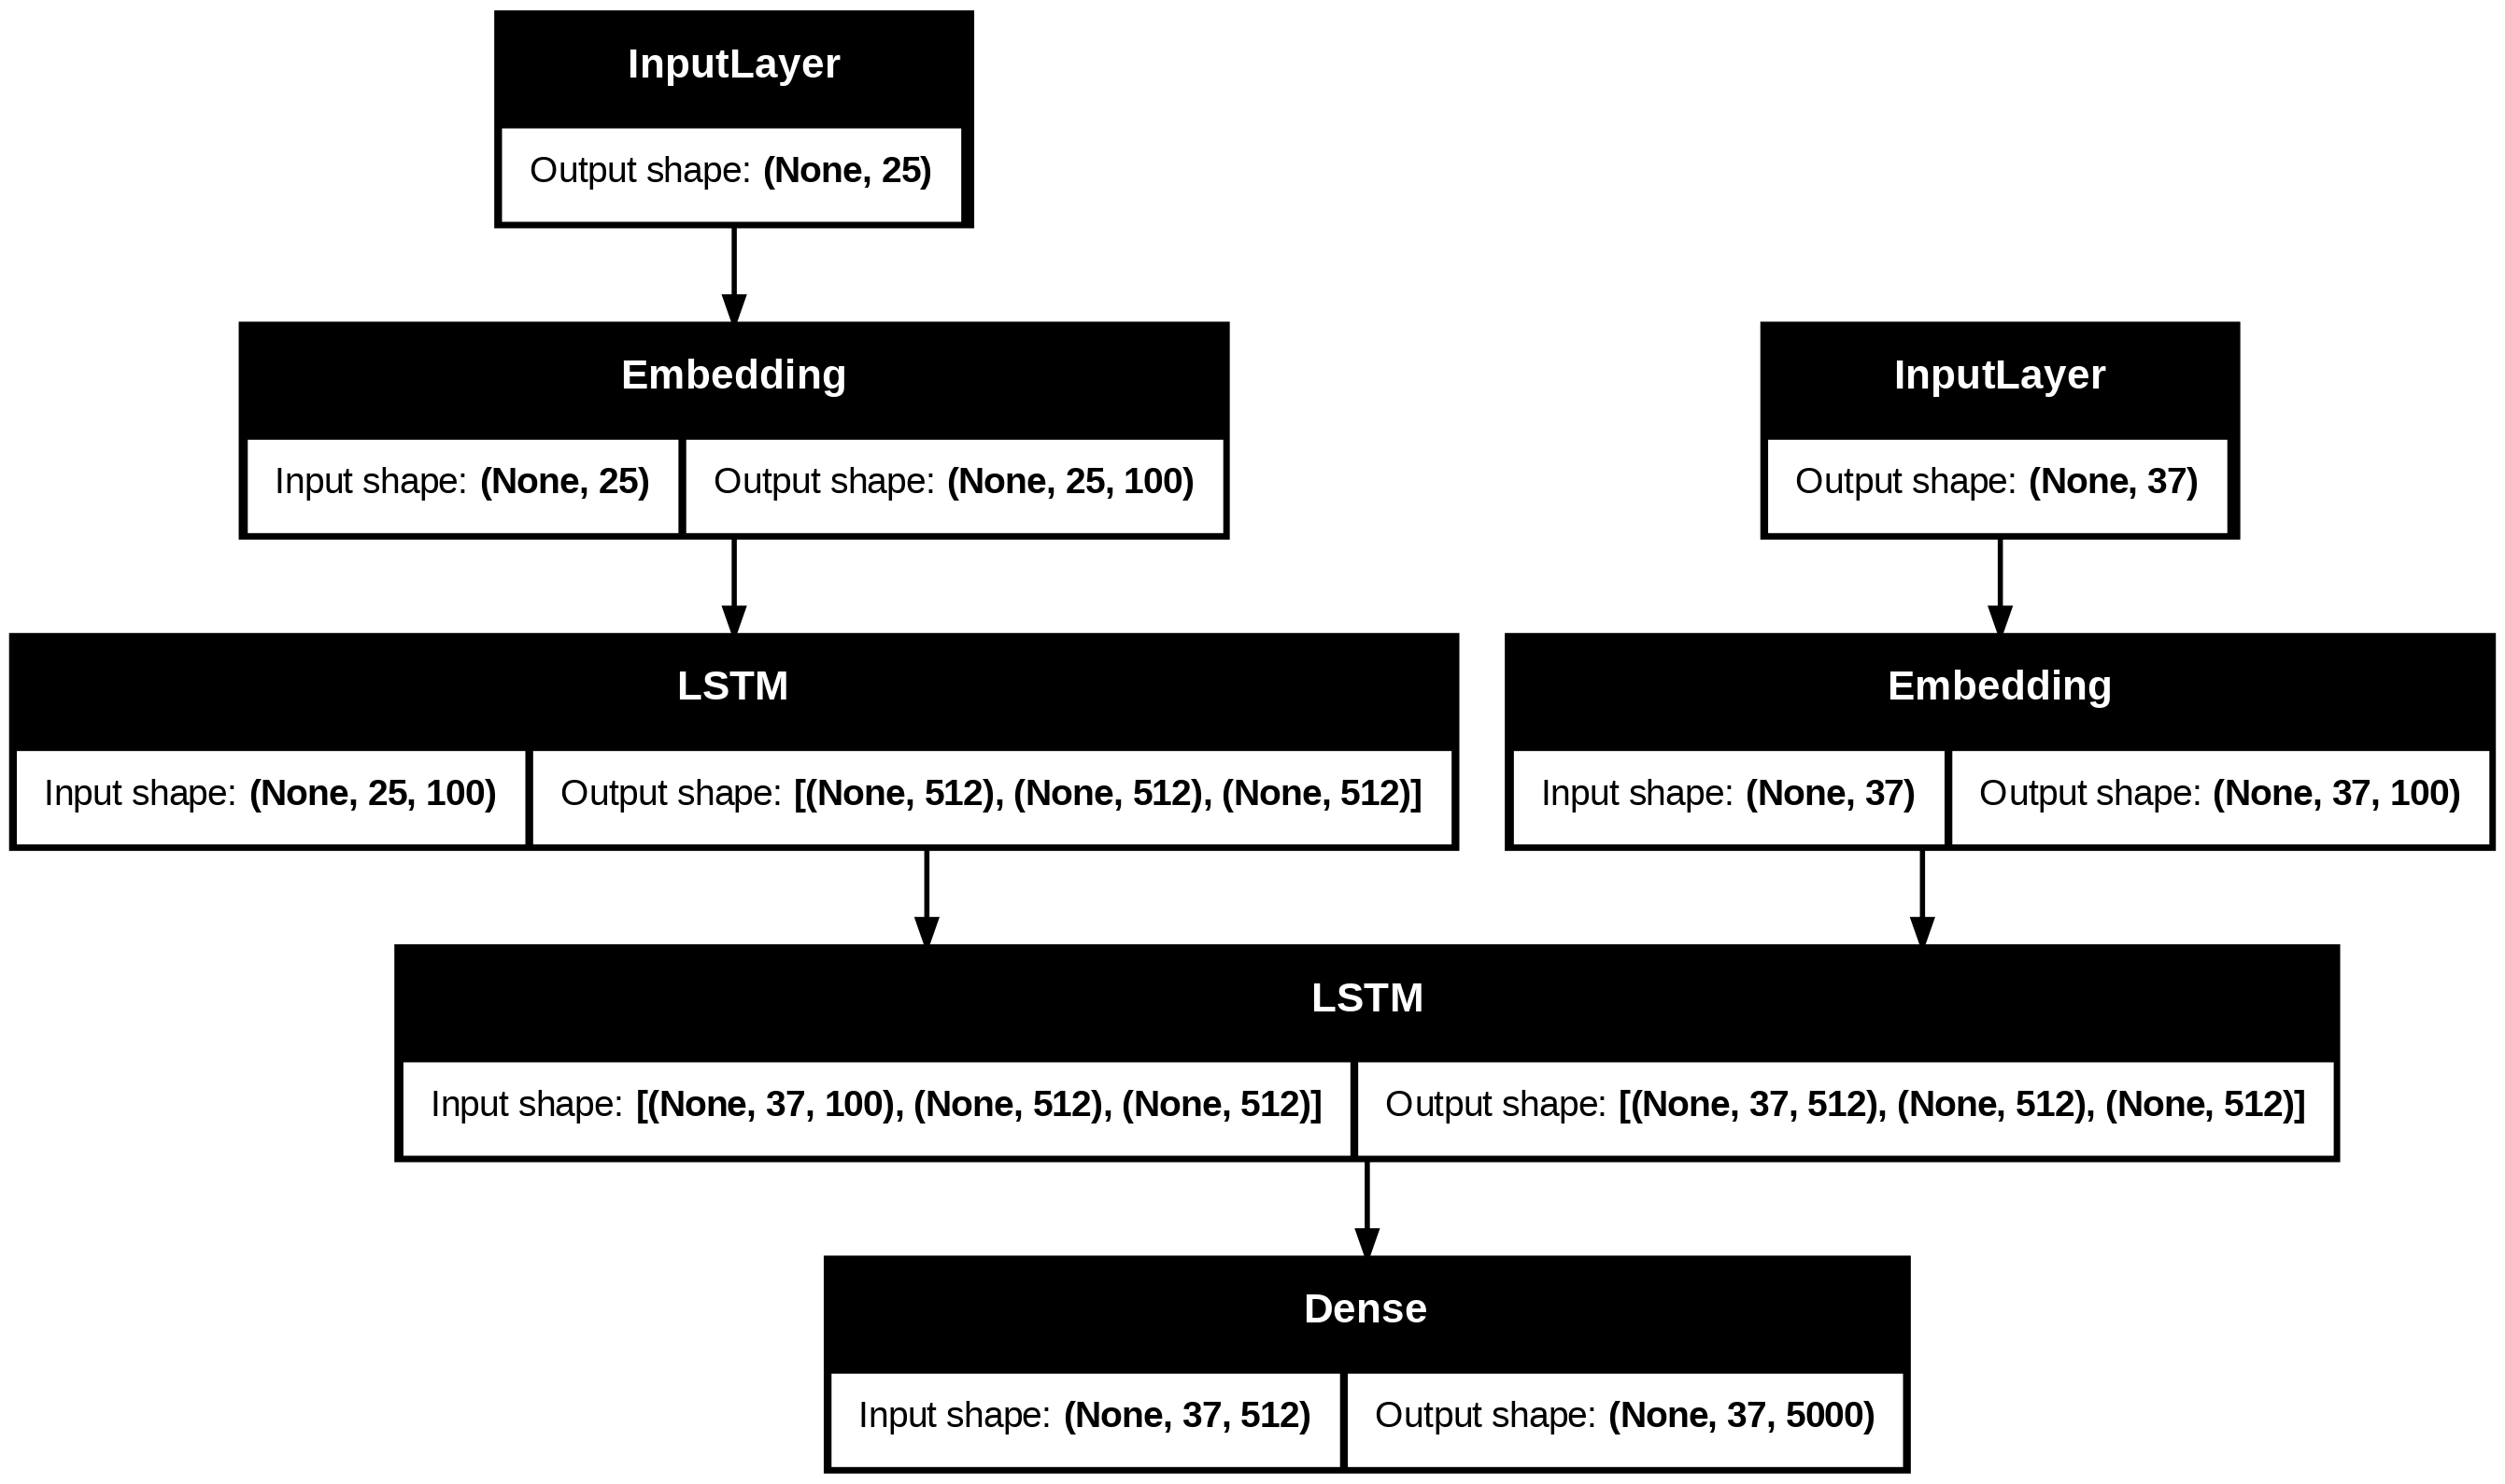

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(decoder_teacher_forcing_model, show_shapes=True)

##### 학습

In [11]:
decoder_teacher_forcing_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = decoder_teacher_forcing_model.fit(
    [Q_inputs_padded, A_inputs_padded],
    A_targets_padded,
    batch_size=64,
    epochs=70,
    validation_split=0.2
)

Epoch 1/70
148/148 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.7699 - loss: 2.4432 - val_accuracy: 0.8055 - val_loss: 1.4432
Epoch 2/70
148/148 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.8405 - loss: 1.1237 - val_accuracy: 0.8091 - val_loss: 1.3653
Epoch 3/70
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.8425 - loss: 1.0587 - val_accuracy: 0.8128 - val_loss: 1.3364
Epoch 4/70
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.8458 - loss: 1.0198 - val_accuracy: 0.8152 - val_loss: 1.3216
Epoch 5/70
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8507 - loss: 0.9725 - val_accuracy: 0.8172 - val_loss: 1.3071
Epoch 6/70
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.8530 - loss: 0.9451 - val_accuracy: 0.8195 - val_loss: 1.2995
Epoch 7/70
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.8528 - loss: 0.9316 - val_accuracy: 0.8215 - val_loss: 1.2864
Epoch 8/70
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.8566 - loss: 0.8893 - 

In [12]:
# 모델 저장
decoder_teacher_forcing_model.save('decoder_teacher_forcing_model.keras')

In [13]:
# 모델 로드
# from tensorflow.keras.models import load_model

# decoder_teacher_forcing_model = load_model('decoder_teacher_forcing_model.keras')

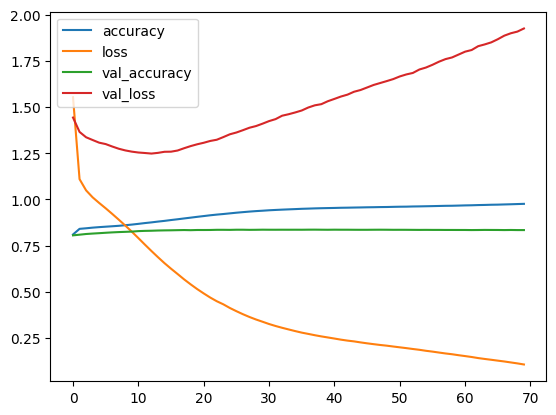

In [14]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot()
plt.show()

### 모델 추론

##### 디코더(추론 모델) 생성

In [15]:
decoder_hidden_state = layers.Input(shape=(LATENT_DIM,))
decoder_cell_state = layers.Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_hidden_state, decoder_cell_state]

decoder_single_input = layers.Input(shape=(1,))

x = decoder_embedding_layer(decoder_single_input)

x, h, c = decoder_lstm(x, initial_state=decoder_states_inputs)
decoder_states = [h, c]

decoder_outputs = decoder_dense(x)

decoder_inference_model = models.Model(
    inputs=[decoder_single_input] + decoder_states_inputs,
    outputs=[decoder_outputs] + decoder_states
)
decoder_inference_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 100)    │    500,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 1, 512),  │  1,255,424 │ embedding_1[1][0… │
│                     │ (None, 512),      │            │ input_layer_2[0]… │
│                     │ (None, 512)]      │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 5000)   │  2,565,000 │ lstm_1[1][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,320,424 (16.48 MB)

 Trainable params: 4,320,424 (16.48 MB)

 Non-trainable params: 0 (0.00 B)

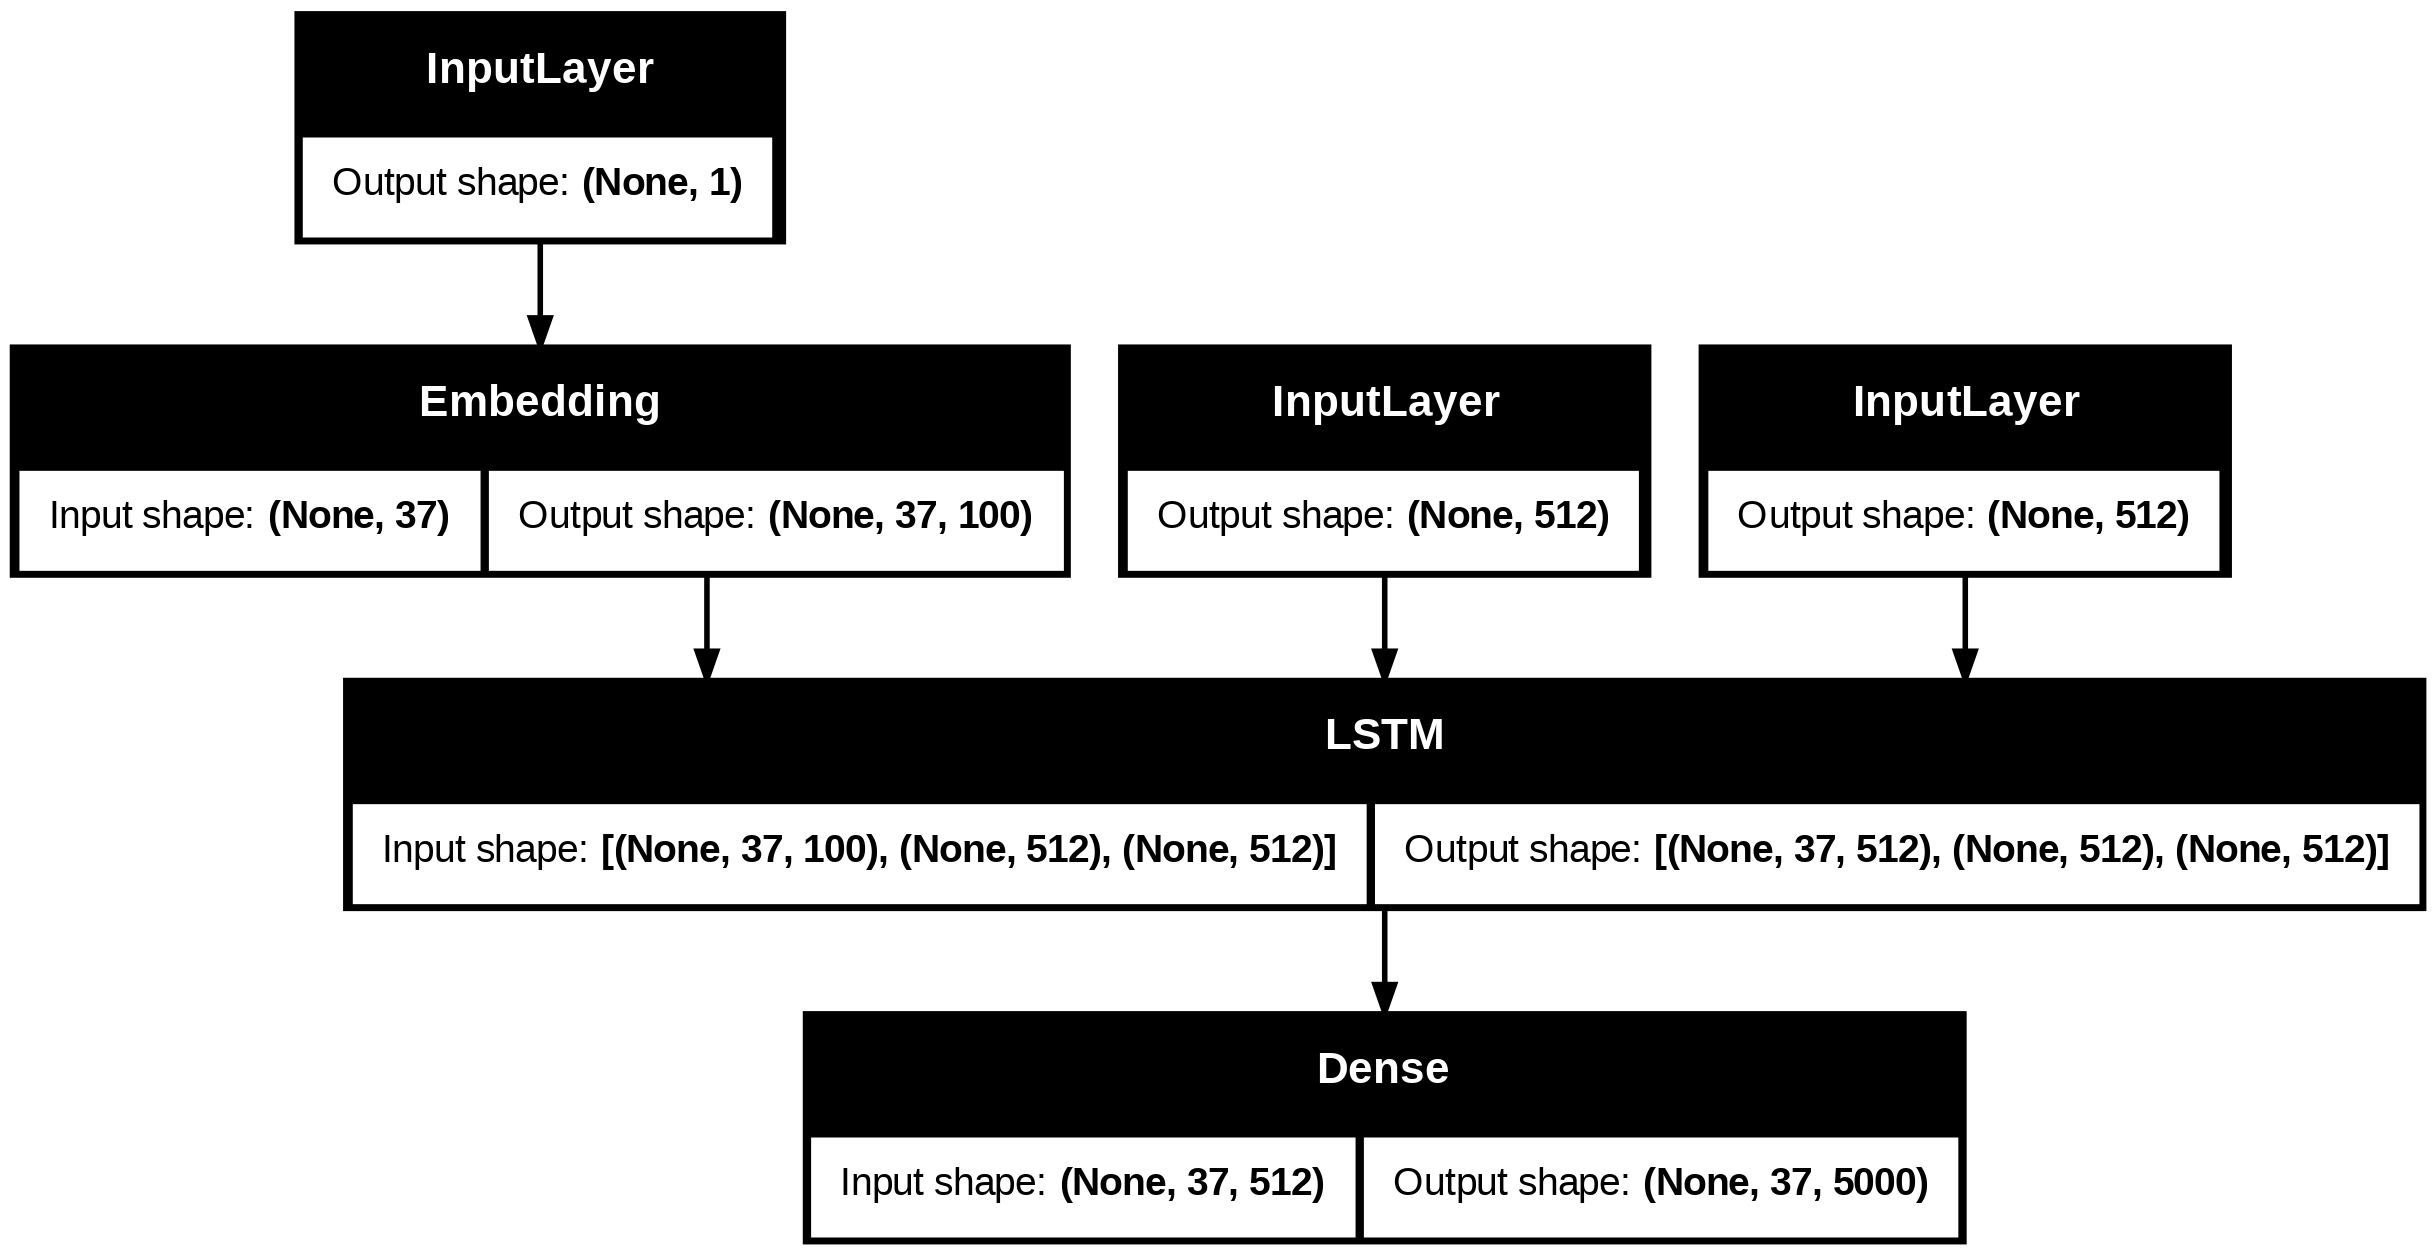

In [16]:
plot_model(decoder_inference_model, show_shapes=True)

##### 추론 함수

In [17]:
def translate(input_seq):
    states_value = encoder_model.predict(input_seq, verbose=0)
    decoder_states_value = states_value

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = sp.bos_id()

    output_sentence_ids = []

    for _ in range(a_max_len):
        output_tokens, h, c = decoder_inference_model.predict([target_seq] + decoder_states_value, verbose=0)

        pred_index = np.argmax(output_tokens[0, 0, :])

        if pred_index == sp.eos_id():
            break

        output_sentence_ids.append(int(pred_index))

        target_seq[0, 0] = pred_index
        decoder_states_value = [h, c]

    return sp.decode(output_sentence_ids)

In [23]:
def ask(question):
    input_ids = sp.encode_as_ids(question)
    input_seq = pad_sequences([input_ids], maxlen=q_max_len, padding='post')

    answer = translate(input_seq)
    print(f"질문: {question}")
    print(f"답변: {answer}\n")

ask("오늘 점심 뭐 먹을까?")

질문: 오늘 점심 뭐 먹을까?
답변: 맛있는 거 드세요.



##### 테스트

### 간단한 Chatbot 구현

1. 사용자의 입력을 받아 (처리)
2. 추론 함수에 전달해서
3. 응답을 출력
4. 1~3 '종료' 전까지 반복

In [24]:
print("안녕하세요, 맹구님!")
print("'종료'를 입력하면 대화가 종료됩니다.")

while True:
    user_input = input("Question:")
    if user_input == '종료':
        print("내일 또 만나요 👋🏻")
        break
    ask(user_input)

안녕하세요, 맹구님!
'종료'를 입력하면 대화가 종료됩니다.
Question:오늘 날씨 어때?
질문: 오늘 날씨 어때?
답변: 다행이에요.

Question:오늘 점심 뭐 먹을까?
질문: 오늘 점심 뭐 먹을까?
답변: 맛있는 거 드세요.

Question:드라마 추천해줘!
질문: 드라마 추천해줘!
답변: 서로에게 힘든 일이니까요.

Question:종료
내일 또 만나요 👋🏻
